<a href="https://colab.research.google.com/github/tux2won/EPOCH_Warmingup/blob/main/week%201%20%5B4%EC%9E%A5%5D%20/%20chaewon_12%EB%B2%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사이킷런을 사용하지 않고 넘파이만 사용하여 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해보세요. 이를 붓꽃 데이터셋 같은 분류 작업에 사용해보세요.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

np.random.seed(42)

In [28]:
def load_iris_data():
    """
    붓꽃 데이터 로드 및 처리
    """
    # 붓꽃 데이터셋 로드
    iris = load_iris()
    X = iris.data[:, 2:4]  # 꽃잎 길이와 너비만 사용 (시각화를 위해)
    y = iris.target

    return X, y, iris.target_names

# 데이터 로드
X, y, class_names = load_iris_data()

# 데이터 확인
print("특성 행렬 크기:", X.shape)
print("타겟 벡터 크기:", y.shape)
print("클래스 이름:", class_names)

# 처음 5개 데이터 샘플 출력
print("\n첫 5개 데이터 샘플:")
for i in range(5):
    print(f"샘플 {i+1}: 특성 = {X[i]}, 클래스 = {class_names[y[i]]}")

특성 행렬 크기: (150, 2)
타겟 벡터 크기: (150,)
클래스 이름: ['setosa' 'versicolor' 'virginica']

첫 5개 데이터 샘플:
샘플 1: 특성 = [1.4 0.2], 클래스 = setosa
샘플 2: 특성 = [1.4 0.2], 클래스 = setosa
샘플 3: 특성 = [1.3 0.2], 클래스 = setosa
샘플 4: 특성 = [1.5 0.2], 클래스 = setosa
샘플 5: 특성 = [1.4 0.2], 클래스 = setosa


In [29]:
def split_data(X, y, test_ratio=0.2, validation_ratio=0.2):
    """
    데이터를 훈련, 검증, 테스트 세트로 분할
    """
    # 데이터 분할 준비
    total_size = len(X)
    test_size = int(total_size * test_ratio)
    validation_size = int(total_size * validation_ratio)
    train_size = total_size - test_size - validation_size

    # 무작위 인덱스 생성
    rnd_indices = np.random.permutation(total_size)

    # 데이터셋 분할
    X_train_raw = X[rnd_indices[:train_size]]
    y_train = y[rnd_indices[:train_size]]

    X_valid_raw = X[rnd_indices[train_size:-test_size]]
    y_valid = y[rnd_indices[train_size:-test_size]]

    X_test_raw = X[rnd_indices[-test_size:]]
    y_test = y[rnd_indices[-test_size:]]

    # 편향 항 추가 (1로 채워진 열)
    X_train = np.c_[np.ones(len(X_train_raw)), X_train_raw]
    X_valid = np.c_[np.ones(len(X_valid_raw)), X_valid_raw]
    X_test = np.c_[np.ones(len(X_test_raw)), X_test_raw]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 데이터 분할
X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(X, y)

# 분할된 데이터 크기 확인
print("훈련 세트 특성 행렬 크기:", X_train.shape)
print("훈련 세트 타겟 벡터 크기:", y_train.shape)
print("검증 세트 특성 행렬 크기:", X_valid.shape)
print("검증 세트 타겟 벡터 크기:", y_valid.shape)
print("테스트 세트 특성 행렬 크기:", X_test.shape)
print("테스트 세트 타겟 벡터 크기:", y_test.shape)

훈련 세트 특성 행렬 크기: (90, 3)
훈련 세트 타겟 벡터 크기: (90,)
검증 세트 특성 행렬 크기: (30, 3)
검증 세트 타겟 벡터 크기: (30,)
테스트 세트 특성 행렬 크기: (30, 3)
테스트 세트 타겟 벡터 크기: (30,)


In [30]:
def to_one_hot(y):
    """
    타깃을 원-핫 인코딩으로 변환

    Args:
        y: 클래스 레이블 벡터

    Returns:
        원-핫 인코딩된 레이블
    """
    n_classes = y.max() + 1
    m = len(y)
    one_hot = np.zeros((m, n_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot

# 타겟 변수 원-핫 인코딩
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_valid)
y_test_one_hot = to_one_hot(y_test)

# 원-핫 인코딩 결과 확인
print("원본 타겟 벡터 예시 (처음 5개):", y_train[:5])
print("원-핫 인코딩된 타겟 행렬 예시 (처음 5개):")
print(y_train_one_hot[:5])

원본 타겟 벡터 예시 (처음 5개): [1 0 2 1 1]
원-핫 인코딩된 타겟 행렬 예시 (처음 5개):
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [31]:
def standardize_features(X_train, X_valid, X_test):
    """
    특성을 표준화하는 함수 (편향 열 제외)
    """
    # 훈련셋의 평균과 표준편차 계산 (편향 열 제외)
    mean = X_train[:, 1:].mean(axis=0)
    std = X_train[:, 1:].std(axis=0)

    # 표준화 적용 (편향 열 제외)
    X_train_scaled = X_train.copy()
    X_valid_scaled = X_valid.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[:, 1:] = (X_train[:, 1:] - mean) / std
    X_valid_scaled[:, 1:] = (X_valid[:, 1:] - mean) / std
    X_test_scaled[:, 1:] = (X_test[:, 1:] - mean) / std

    return X_train_scaled, X_valid_scaled, X_test_scaled, mean, std

# 특성 표준화
X_train, X_valid, X_test, mean, std = standardize_features(X_train, X_valid, X_test)

# 표준화 결과 확인
print("원본 특성 행렬 평균 (편향 제외):", mean)
print("원본 특성 행렬 표준편차 (편향 제외):", std)
print("\n표준화된 훈련 데이터 처음 3개 샘플:")
print(X_train[:3])


원본 특성 행렬 평균 (편향 제외): [3.56111111 1.12      ]
원본 특성 행렬 표준편차 (편향 제외): [1.78130379 0.76785415]

표준화된 훈련 데이터 처음 3개 샘플:
[[ 1.          0.63935691  0.10418645]
 [ 1.         -1.04480275 -1.06791114]
 [ 1.          1.87440733  1.53675017]]


In [32]:
def softmax(logits):
    """
    소프트맥스 함수
    """
    # 수치적 안정성을 위해 최대값 빼기
    logits_shifted = logits - np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits_shifted)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def compute_cost(X, y_one_hot, theta, C=None):
    """
    크로스 엔트로피 손실 계산 (선택적으로 L2 정규화 포함)
    """
    m = len(X)
    epsilon = 1e-15  # 로그 함수 오류 방지

    logits = X @ theta
    y_proba = softmax(logits)

    # 크로스 엔트로피 손실
    cross_entropy = -np.sum(y_one_hot * np.log(y_proba + epsilon)) / m

    # L2 정규화 추가 (편향항 제외)
    if C is not None:
        l2_loss = 0.5 * np.sum(theta[1:] ** 2)
        return cross_entropy + l2_loss / C

    return cross_entropy

# 소프트맥스 함수 테스트
test_logits = np.array([[2.0, 1.0, 0.1], [0.1, 1.0, 3.0]])
test_probs = softmax(test_logits)
print("테스트 로짓:", test_logits)
print("소프트맥스 확률:", test_probs)
print("각 행의 합 (1이 되어야 함):", test_probs.sum(axis=1))

테스트 로짓: [[2.  1.  0.1]
 [0.1 1.  3. ]]
소프트맥스 확률: [[0.65900114 0.24243297 0.09856589]
 [0.04622407 0.11369288 0.84008305]]
각 행의 합 (1이 되어야 함): [1. 1.]


In [34]:
def predict(X, theta):
    """
    주어진 가중치로 예측 수행
    """
    logits = X @ theta
    y_proba = softmax(logits)
    return np.argmax(y_proba, axis=1), y_proba

def accuracy(y_true, y_pred):
    """
    예측 정확도 계산
    """
    # 배열 길이가 일치하는지 확인
    if len(y_true) != len(y_pred):
        raise ValueError(f"y_true 길이({len(y_true)})와 y_pred 길이({len(y_pred)})가 일치하지 않습니다!")

    return np.mean(np.array(y_true) == np.array(y_pred))

In [35]:
def batch_gradient_descent_with_early_stopping_and_l2(
    X_train, y_train_one_hot, X_valid, y_valid_one_hot, y_train, y_valid,
    learning_rate=0.01, max_epochs=10000, C=None, patience=10, tol=1e-4):
    """
    L2 정규화와 조기 종료가 적용된 배치 경사 하강법

    Args:
        X_train: 훈련 특성 행렬 (편향 포함)
        y_train_one_hot: 원-핫 인코딩된 훈련 타겟
        X_valid: 검증 특성 행렬 (편향 포함)
        y_valid_one_hot: 원-핫 인코딩된 검증 타겟
        y_train: 원본 훈련 타겟 레이블
        y_valid: 원본 검증 타겟 레이블
        learning_rate: 학습률
        max_epochs: 최대 에폭 수
        C: L2 정규화 강도의 역수 (클수록 약한 정규화)
        patience: 손실이 개선되지 않는 최대 에폭 수
        tol: 손실 개선 여부를 판단하는 임계값

    Returns:
        학습된 가중치 행렬, 훈련 및 검증 손실 이력
    """
    m = len(X_train)
    n_features = X_train.shape[1]
    n_classes = y_train_one_hot.shape[1]

    # 가중치 행렬 무작위 초기화
    theta = np.random.randn(n_features, n_classes) * 0.01

    # 손실 기록
    train_losses = []
    valid_losses = []

    # 조기 종료 변수
    best_valid_loss = float('inf')
    best_theta = None
    no_improvement = 0

    # 에폭 반복
    for epoch in range(max_epochs):
        # 순방향 계산
        logits = X_train @ theta
        y_proba = softmax(logits)

        # 그레이디언트 계산
        error = y_proba - y_train_one_hot
        gradients = 1/m * X_train.T @ error

        # L2 정규화 그레이디언트 추가 (편향 제외)
        if C is not None:
            gradients[1:] += theta[1:] / C

        # 가중치 업데이트
        theta = theta - learning_rate * gradients

        # 훈련 및 검증 손실 계산
        train_loss = compute_cost(X_train, y_train_one_hot, theta, C)
        valid_loss = compute_cost(X_valid, y_valid_one_hot, theta, C)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # 에폭 결과 출력 (일부 에폭만)
        if epoch % 1000 == 0:
            y_train_pred, _ = predict(X_train, theta)
            y_valid_pred, _ = predict(X_valid, theta)

            # 예측 결과와 실제 레이블의 크기가 같은지 확인
            train_acc = np.mean(np.array(y_train) == np.array(y_train_pred))
            valid_acc = np.mean(np.array(y_valid) == np.array(y_valid_pred))

            print(f"에폭 {epoch}: 훈련 손실 = {train_loss:.4f}, 검증 손실 = {valid_loss:.4f}, "
                  f"훈련 정확도 = {train_acc:.4f}, 검증 정확도 = {valid_acc:.4f}")

        # 조기 종료 로직
        if valid_loss < best_valid_loss - tol:
            best_valid_loss = valid_loss
            best_theta = theta.copy()
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"검증 손실이 {patience}번 동안 개선되지 않아 {epoch+1} 에폭에서 조기 종료합니다.")
            if best_theta is not None:
                theta = best_theta
            break

    # 최적의 모델 선택
    if best_theta is not None:
        theta = best_theta

    return theta, train_losses, valid_losses

In [36]:
# 하이퍼파라미터 설정
learning_rate = 0.01
max_epochs = 10000
C = 100  # L2 정규화 강도의 역수 (클수록 약한 정규화)
patience = 50
tol = 1e-5

# 모델 학습
print("조기 종료와 L2 정규화가 적용된 소프트맥스 회귀 모델 학습 중...")
theta, train_losses, valid_losses = batch_gradient_descent_with_early_stopping_and_l2(
    X_train, y_train_one_hot, X_valid, y_valid_one_hot, y_train, y_valid,
    learning_rate=learning_rate, max_epochs=max_epochs,
    C=C, patience=patience, tol=tol
)

조기 종료와 L2 정규화가 적용된 소프트맥스 회귀 모델 학습 중...
에폭 0: 훈련 손실 = 1.0972, 검증 손실 = 1.0981, 훈련 정확도 = 0.3889, 검증 정확도 = 0.2667
에폭 1000: 훈련 손실 = 0.3939, 검증 손실 = 0.4429, 훈련 정확도 = 0.9556, 검증 정확도 = 0.9333
에폭 2000: 훈련 손실 = 0.3277, 검증 손실 = 0.3800, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9000
에폭 3000: 훈련 손실 = 0.2999, 검증 손실 = 0.3542, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333
에폭 4000: 훈련 손실 = 0.2860, 검증 손실 = 0.3417, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333
에폭 5000: 훈련 손실 = 0.2784, 검증 손실 = 0.3351, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333
에폭 6000: 훈련 손실 = 0.2739, 검증 손실 = 0.3315, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333
에폭 7000: 훈련 손실 = 0.2712, 검증 손실 = 0.3294, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333
에폭 8000: 훈련 손실 = 0.2695, 검증 손실 = 0.3281, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333
에폭 9000: 훈련 손실 = 0.2684, 검증 손실 = 0.3274, 훈련 정확도 = 0.9667, 검증 정확도 = 0.9333


In [37]:
# 모델 평가
print("\n모델 평가:")
y_train_pred, _ = predict(X_train, theta)
y_valid_pred, _ = predict(X_valid, theta)
y_test_pred, _ = predict(X_test, theta)

train_acc = np.mean(np.array(y_train) == np.array(y_train_pred))
valid_acc = np.mean(np.array(y_valid) == np.array(y_valid_pred))
test_acc = np.mean(np.array(y_test) == np.array(y_test_pred))

print(f"최종 훈련 정확도: {train_acc:.4f}")
print(f"최종 검증 정확도: {valid_acc:.4f}")
print(f"최종 테스트 정확도: {test_acc:.4f}")



모델 평가:
최종 훈련 정확도: 0.9667
최종 검증 정확도: 0.9333
최종 테스트 정확도: 0.9667


<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-38-baab7607de38>:13: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipytho

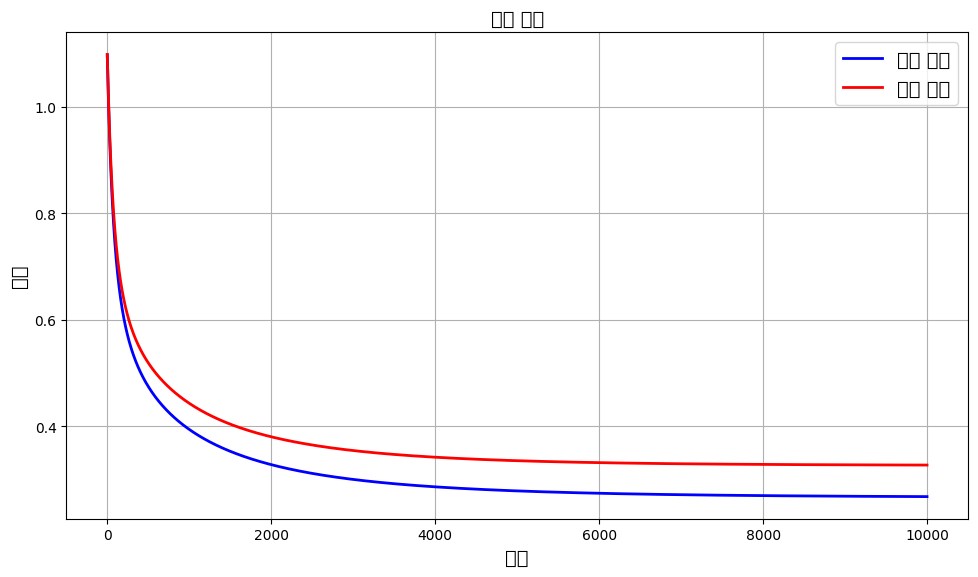

In [38]:
def plot_learning_curves(train_losses, valid_losses):
    """
    학습 곡선 시각화
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', linewidth=2, label='훈련 손실')
    plt.plot(valid_losses, 'r-', linewidth=2, label='검증 손실')
    plt.xlabel('에폭')
    plt.ylabel('손실')
    plt.title('학습 곡선')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 학습 곡선 시각화
plot_learning_curves(train_losses, valid_losses)


결정 경계 시각화...


<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 44867 (\N{HANGUL SYLLABLE GGOC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 51086 (\N{HANGUL SYLLABLE IP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-587e6d91387b>:56: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipytho

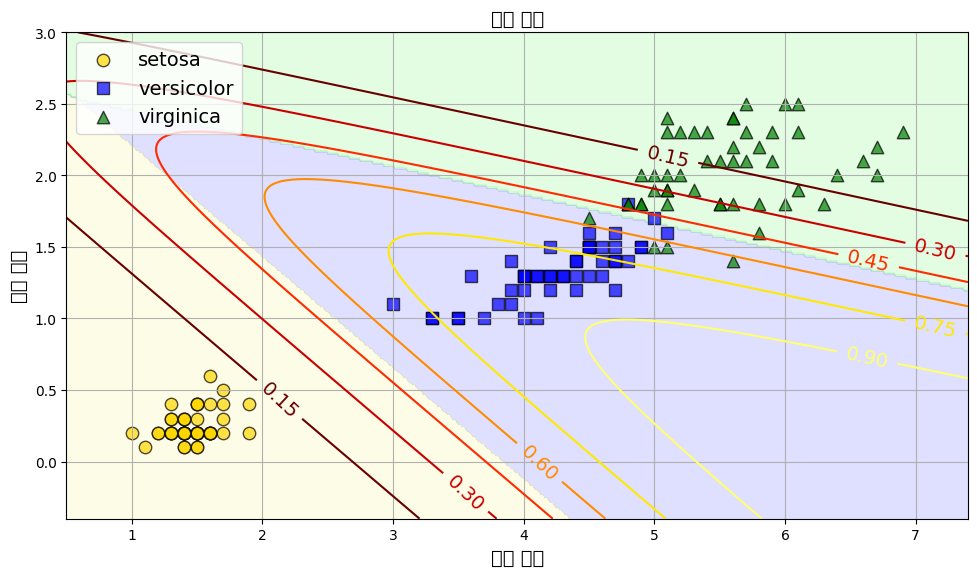

In [40]:
def plot_decision_boundary(X, y, theta, feature_names=None, class_names=None, mean=None, std=None):
    """
    결정 경계 시각화
    """
    # 그리드 생성
    x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, 500),
        np.linspace(x1_min, x1_max, 200)
    )

    # 그리드 포인트에 대한 특성 행렬 생성
    grid = np.c_[xx0.ravel(), xx1.ravel()]

    # 데이터 표준화 (mean과 std가 제공된 경우)
    if mean is not None and std is not None:
        grid = (grid - mean) / std

    # 그리드 포인트에 편향 추가
    grid_with_bias = np.c_[np.ones(len(grid)), grid]

    # 예측
    y_pred, y_proba = predict(grid_with_bias, theta)

    # 맞춤형 컬러맵
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

    # 결정 경계 시각화
    plt.figure(figsize=(10, 6))
    plt.contourf(xx0, xx1, y_pred.reshape(xx1.shape), cmap=custom_cmap, alpha=0.3)

    # 데이터 포인트 플롯
    markers = ['o', 's', '^']
    colors = ['gold', 'blue', 'green']

    for i in range(len(np.unique(y))):
        plt.scatter(
            X[y == i, 0], X[y == i, 1],
            marker=markers[i], c=colors[i], edgecolors='k', s=80, alpha=0.7,
            label=class_names[i] if class_names is not None else f"Class {i}"
        )

    # 확률 등고선 (두 번째 클래스에 대한)
    if len(np.unique(y)) > 1:
        contour = plt.contour(xx0, xx1, y_proba[:, 1].reshape(xx1.shape), cmap="hot")
        plt.clabel(contour, inline=1)

    # 축 레이블
    plt.xlabel(feature_names[0] if feature_names else "Feature 0")
    plt.ylabel(feature_names[1] if feature_names else "Feature 1")
    plt.title("결정 경계")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 결정 경계 시각화
print("\n결정 경계 시각화...")
feature_names = ["꽃잎 길이", "꽃잎 너비"]

# 원본 데이터 사용 (이미 꽃잎 길이, 너비만 선택되어 있음)
plot_decision_boundary(X, y, theta, feature_names, class_names, mean, std)


학습된 가중치:
setosa: [-0.17908373 -2.20546553 -1.90617406]
versicolor: [ 1.56766668  0.47559809 -0.41955278]
virginica: [-1.41677023  1.73025295  2.33278559]


<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 44867 (\N{HANGUL SYLLABLE GGOC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 51086 (\N{HANGUL SYLLABLE IP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-d284c87f07f2>:19: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython

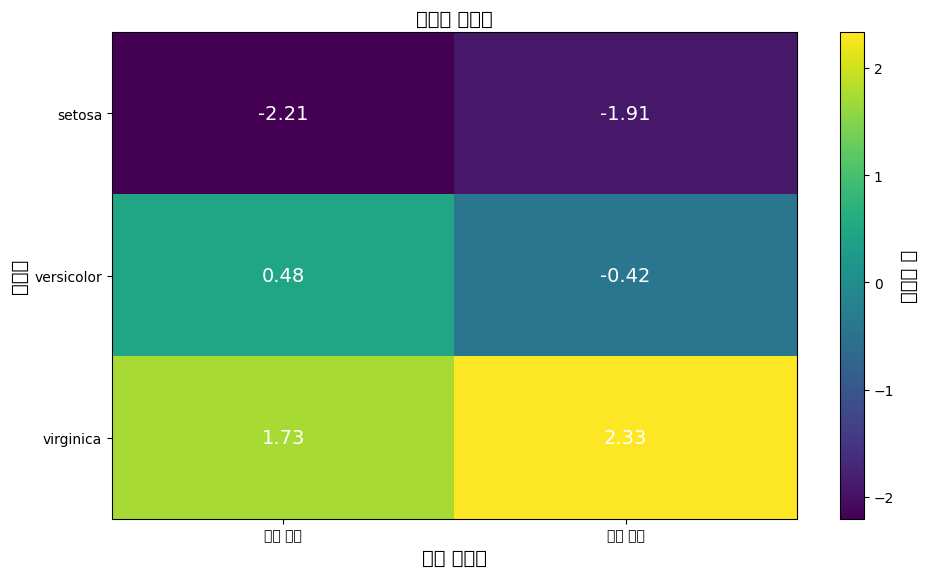


절편(편향):
setosa: -0.1791
versicolor: 1.5677
virginica: -1.4168

특성 가중치:
setosa: 꽃잎 길이 = -2.2055, 꽃잎 너비 = -1.9062
versicolor: 꽃잎 길이 = 0.4756, 꽃잎 너비 = -0.4196
virginica: 꽃잎 길이 = 1.7303, 꽃잎 너비 = 2.3328


In [41]:
# 가중치 시각화
print("\n학습된 가중치:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {theta[:, i]}")

# 가중치 시각화 (히트맵)
plt.figure(figsize=(10, 6))
plt.imshow(theta[1:].T, cmap='viridis', aspect='auto')
plt.colorbar(label='가중치 값')
plt.xlabel('특성 인덱스')
plt.ylabel('클래스')
plt.title('가중치 히트맵')
plt.xticks(np.arange(2), ['꽃잎 길이', '꽃잎 너비'])
plt.yticks(np.arange(3), class_names)
for i in range(3):
    for j in range(2):
        plt.text(j, i, f'{theta[j+1, i]:.2f}',
                 ha='center', va='center', color='white')
plt.tight_layout()
plt.show()

# 절편과 가중치 출력
print("\n절편(편향):")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {theta[0, i]:.4f}")

print("\n특성 가중치:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: 꽃잎 길이 = {theta[1, i]:.4f}, 꽃잎 너비 = {theta[2, i]:.4f}")